In [130]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch 

In [ ]:
# From ChatGTP
def map_parties(year):
    if year >= 2023:
        return "BBB, VVD, GroenLinks, D66, PvdA, PVV"
    elif year >= 2019:
        return "Forum for Democracy (FvD), VVD, CDA, GroenLinks, D66"
    elif year >= 2015:
        return "VVD, CDA, D66, SP"
    elif year >= 2011:
        return "VVD, CDA, D66, PVV"
    elif year >= 2007:
        return "CDA, VVD, PvdA"
    elif year >= 2003:
        return "CDA, VVD, D66"
    elif year >= 1999:
        return "CDA, VVD, D66"
    elif year >= 1995:
        return "CDA, VVD, D66"
    else:
        return "CDA, PvdA, VVD"
    
def map_theme(category):
    """Determine the theme(s) for a given category using if statements."""
    themes = []

    if category in [
        '3.2 Verduurzaming gebouwde omgeving',
        
        '3.1 Schone en duurzame elektriciteitsvoorziening',
        '3.3 Duurzaam energie-en grondstoffensysteem in de industrie'
    ]:
        themes.append('Duurzaamheid')

    if category in [
        '5.1 Gezonde natuur',
        '5.3 Leven met water',
        '7.1 Bevorderen verbetering milieukwaliteit en gezondheid',
        '7.3 Klimaatbestendig Zuid-Holland'
    ]:
        themes.append('Natuur & Milieu')

    if category in [
        '2.1 Snel van A naar B',
        '2.2 Beheer en onderhoud: op orde en duurzaam',
        '2.1 Duurzame en veilige bereikbaarheid voor iedereen',
        '2.3 Veilig en duurzaam'
    ]:
        themes.append('Mobiliteit')

    if category in [
        '4.3 Erfgoed, cultuur en toerisme',
        '4.2 Erfgoed en Cultuur'
    ]:
        themes.append('Cultuur & Erfgoed')

    if category in [
        '4.1 Innovatie: richting duurzaam en digitaal',
        '4.1 Toekomstbestendig economisch vestigingsklimaat',
        '4.2 Creëren van een rijk vestigingsklimaat'
    ]:
        themes.append('Economie & Innovatie')

    if category in [
        '5.2 Toekomstbestendige landbouw',
        '5.2 Transitie landbouw'
    ]:
        themes.append('Landbouw & Voedsel')

    if category in [
        '6.1 Voldoende juiste woningen op de juiste plek',
        '6.1 Wonen'
    ]:
        themes.append('Wonen')

    if category in [
        '1.1 Beter bestuur',
        '1.2 Sterke samenleving'
    ]:
        themes.append('Bestuur')

    if category in [
        "6.3 Afspraken met regio's",
        '6.2 Vitaliteit en kwaliteit in de leefomgeving'
    ]:
        themes.append('Regionale Ontwikkeling')

    if category in [
        '7.2 Bevorderen recreatie duurzame toerisme en sport',
        '7.2 Gezonde en bewegingsvriendelijke leefomgeving'
    ]:
        themes.append('Recreatie & Sport')

    return ", ".join(themes) if themes else "Onbekend Thema"

In [ ]:
results = pd.DataFrame()

In [63]:
# Fetch data from the API
for xi in range(1,json.loads(requests.get("https://subsidieregister.zuid-holland.nl/api/subsidies").text)["paging"]['totaalnrofpages']):
    url = "https://subsidieregister.zuid-holland.nl/api/subsidies?pageno="+str(xi)  # Replace with the actual URL
    response = requests.get(url)

    # Print the response content
    print("Status Code:", response.status_code)
    print("Response Body:", response.text)
    data = json.loads(response.text)
    results = pd.concat([results,pd.DataFrame(data['results'])])

Status Code: 200
Response Body: {"jaar":[{"key":2019,"name":2019},{"key":2020,"name":2020},{"key":2021,"name":2021},{"key":2022,"name":2022},{"key":2023,"name":2023},{"key":2024,"name":2024},{"key":2025,"name":2025}],"doelstellingnaam":[{"key":747329874,"name":"1.1 Beter bestuur"},{"key":1876334538,"name":"1.2 Sterke samenleving"},{"key":925923821,"name":"2.1 Duurzame en veilige bereikbaarheid voor iedereen"},{"key":793722096,"name":"2.1 Snel van A naar B"},{"key":1691094432,"name":"2.2 Beheer en onderhoud: op orde en duurzaam"},{"key":1139444202,"name":"2.3 Veilig en duurzaam"},{"key":974419005,"name":"3.1 Schone en duurzame elektriciteitsvoorziening"},{"key":1474151643,"name":"3.2 Verduurzaming gebouwde omgeving"},{"key":1536477561,"name":"3.3 Duurzaam energie-en grondstoffensysteem in de industrie"},{"key":2036150403,"name":"4.1 Innovatie: richting duurzaam en digitaal"},{"key":1320195002,"name":"4.1 Toekomstbestendig economisch vestigingsklimaat"},{"key":1141146802,"name":"4.2 Creë

KeyboardInterrupt: 

In [102]:
results = pd.read_parquet("subsidie_data_pzh.parquet")

In [68]:
results

,jaar,aanvrager,verleendbedrag,subsidietype,doelstellingnaam,programmanaam,regelingnaam,grondslagnaam,projectnaam,dossiernummer
0,2022,N.V. Nederlandse Gasunie,64800000,projectsubsidie,3.2 Verduurzaming gebouwde omgeving,3 Schone energie voor iedereen,N.V. Nederlandse Gasunie t.b.v. warmteleiding ...,Begroting,WarmtelinQ+,2022/05448
1,2023,Arriva Personenvervoer Nederland B.V.,39552272,boekjaarsubsidie,2.1 Snel van A naar B,2 Bereikbaar Zuid-Holland,SRM 3.2.1 Regionaal openbaar vervoer over weg ...,Regeling,exploitatie OV concessie Zuid Holland Noord,2023/04618
2,2023,Arriva Personenvervoer Nederland B.V.,38911799,boekjaarsubsidie,2.1 Snel van A naar B,2 Bereikbaar Zuid-Holland,SRM 3.2.1 Regionaal openbaar vervoer over weg ...,Regeling,"Concessie Zuid-Holland Noord, exploitatie open...",2022/06351
3,2022,Arriva Personenvervoer Nederland B.V.,34021699,boekjaarsubsidie,2.3 Veilig en duurzaam,2 Bereikbaar Zuid-Holland,Mob - 3 reg vervoer over weg en spoor,Regeling,Boekjaarsubsidie 2022 voor exploitatie openbaa...,2021/07243
4,2023,Qbuzz B.V.,31473884,boekjaarsubsidie,2.1 Snel van A naar B,2 Bereikbaar Zuid-Holland,SRM 3.2.1 Regionaal openbaar vervoer over weg ...,Regeling,exploitatie OV concessie DMG 2024,2023/04654
...,...,...,...,...,...,...,...,...,...,...
15,2024,Stichting Golf voor Gehandicapten,1202,projectsubsidie,7.2 Bevorderen recreatie duurzame toerisme en ...,7 Gezond en veilig Zuid-Holland,Srsg-openstellingsbesluit subsidie sportactivi...,Regeling,De GvoorG competitie 2024,2024/00517
16,2024,AVG restrictie,1200,projectsubsidie,5.2 Toekomstbestendige landbouw,5 Versterken natuur in Zuid-Holland,Srg 2.19 Landbouwadvies,Regeling,AVG restrictie,2024/01055
17,2024,AVG restrictie,1200,projectsubsidie,5.2 Toekomstbestendige landbouw,5 Versterken natuur in Zuid-Holland,Srg 2.19 Landbouwadvies,Regeling,AVG restrictie,2024/01289
18,2024,Stichting Spel en Sport Regio Dordt,1100,projectsubsidie,7.2 Bevorderen recreatie duurzame toerisme en ...,7 Gezond en veilig Zuid-Holland,Srsg-openstellingsbesluit subsidie sportactivi...,Regeling,Drechtspel 2024 (Kampioenen),2024/00530


In [103]:
results['partijen'] = results.apply(lambda x: map_parties(x.jaar), axis=1)

In [104]:
results['doelstellingnaam'].unique()

array(['3.2 Verduurzaming gebouwde omgeving', '2.1 Snel van A naar B',
       '2.3 Veilig en duurzaam', '5.1 Gezonde natuur',
       '2.2 Beheer en onderhoud: op orde en duurzaam',
       '4.3 Erfgoed, cultuur en toerisme',
       '7.2 Gezonde en bewegingsvriendelijke leefomgeving',
       '4.1 Innovatie: richting duurzaam en digitaal',
       '3.1 Schone en duurzame elektriciteitsvoorziening',
       '2.1 Duurzame en veilige bereikbaarheid voor iedereen',
       '5.2 Toekomstbestendige landbouw',
       '3.3 Duurzaam energie-en grondstoffensysteem in de industrie',
       '6.1 Voldoende juiste woningen op de juiste plek',
       '4.2 Creëren van een rijk vestigingsklimaat',
       '4.2 Erfgoed en Cultuur', '5.3 Leven met water',
       '1.1 Beter bestuur',
       '7.1 Bevorderen verbetering milieukwaliteit en gezondheid',
       '4.1 Toekomstbestendig economisch vestigingsklimaat',
       '1.2 Sterke samenleving', '5.2 Transitie landbouw',
       '7.3 Klimaatbestendig Zuid-Holland',
 

In [72]:
results['programmanaam'].unique()

array(['3 Schone energie voor iedereen', '2 Bereikbaar Zuid-Holland',
       '5 Versterken natuur in Zuid-Holland',
       '4 Een concurrerend Zuid-Holland',
       '7 Gezond en veilig Zuid-Holland',
       '6 Sterke steden en dorpen in Zuid-Holland',
       '4 Een welvarend Zuid-Holland', '1 Samen werken aan Zuid-Holland'],
      dtype=object)

In [105]:
results["Thema"] = results.apply(lambda x: map_theme(x.doelstellingnaam), axis=1)

In [114]:
df_grouped =results.groupby(['partijen','jaar', 'Thema']).agg(
    total_subsidy=('verleendbedrag', 'sum'),
    number_of_subsidies=('verleendbedrag', 'count')
).reset_index()

In [124]:
df = df_grouped

In [132]:
df['Thema'].unique()

array(['Bestuur', 'Cultuur & Erfgoed', 'Duurzaamheid',
       'Economie & Innovatie', 'Landbouw & Voedsel', 'Mobiliteit',
       'Natuur & Milieu', 'Regionale Ontwikkeling', 'Wonen',
       'Recreatie & Sport'], dtype=object)

/var/folders/bn/flln7g490l75vv4q25m_pgfw0000gn/T/ipykernel_23016/2645765398.py:123: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


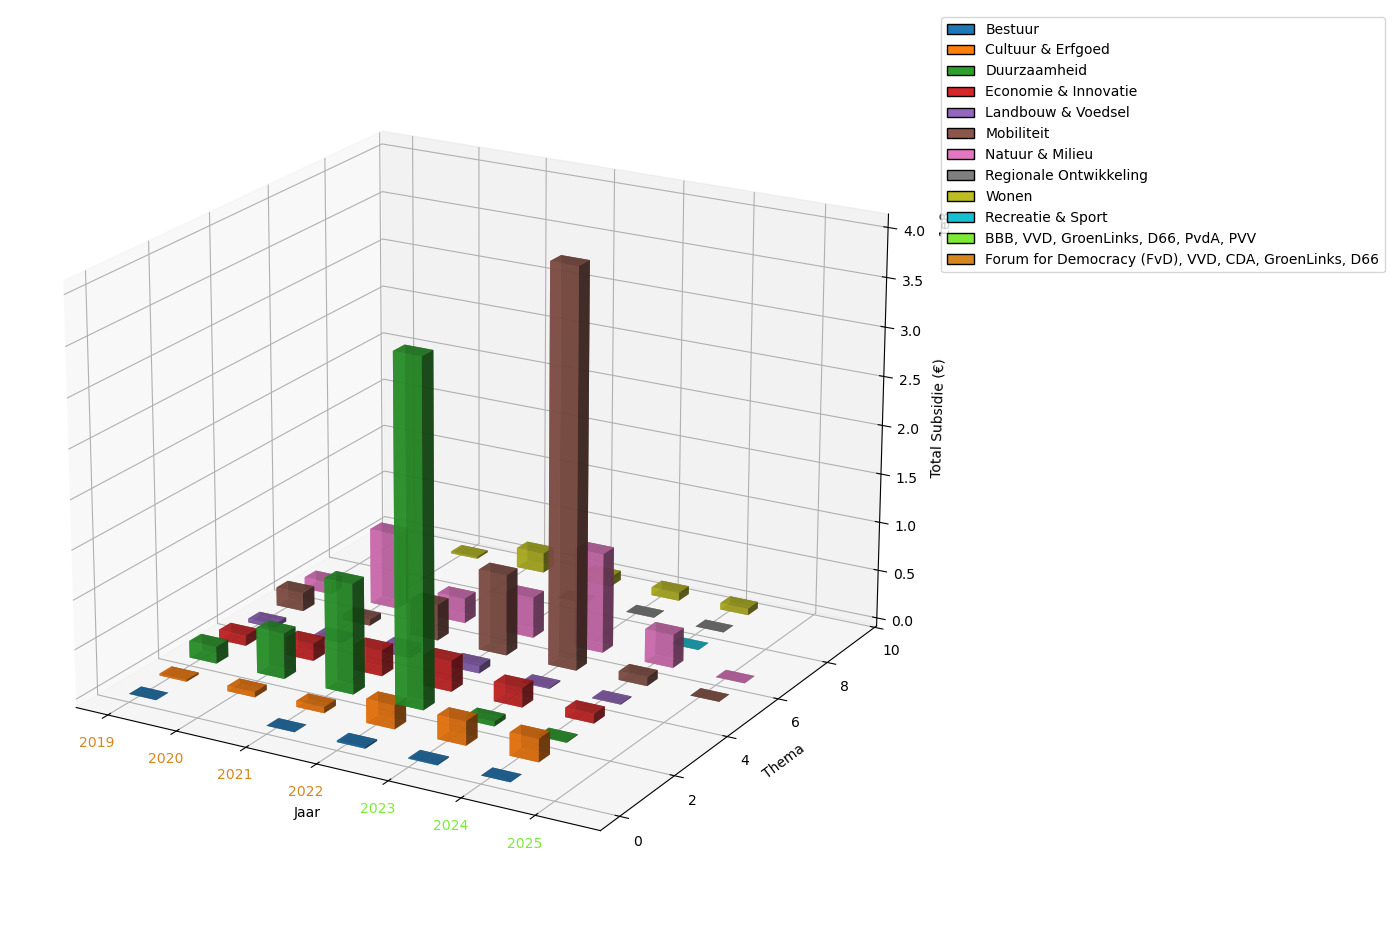

In [145]:
parties_colors = {
    "BBB, VVD, GroenLinks, D66, PvdA, PVV":  "#7deb34",
    "Forum for Democracy (FvD), VVD, CDA, GroenLinks, D66": "#d6861e",
}


theme_colors = {
    'Bestuur': '#1f77b4',
    'Cultuur & Erfgoed': '#ff7f0e',
    'Duurzaamheid': '#2ca02c',
    'Economie & Innovatie': '#d62728',
    'Landbouw & Voedsel': '#9467bd',
    'Mobiliteit': '#8c564b',
    'Natuur & Milieu': '#e377c2',
    'Regionale Ontwikkeling': '#7f7f7f',
    'Wonen': '#bcbd22',
    'Recreatie & Sport': '#17becf'
}

def get_theme_color(thema):
    """Return the color for a given Thema. Fallback to 'gray' if not in the dict."""
    return theme_colors.get(thema, 'gray')

# -----------------------------------------------------------
# 5) Convert jaar (X-axis) and Thema (Y-axis) to numeric idx
# -----------------------------------------------------------
unique_years = sorted(df['jaar'].unique())
unique_themas = sorted(df['Thema'].unique())

year_to_index = {year: i for i, year in enumerate(unique_years)}
thema_to_index = {thema: i for i, thema in enumerate(unique_themas)}

# -----------------------------------------------------------
# 6) Create 3D plot
# -----------------------------------------------------------
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

dx = 0.4
dy = 0.4

for _, row in df.iterrows():
    x_index = year_to_index[row['jaar']]
    y_index = thema_to_index[row['Thema']]
    
    z_lower = 0
    z_height = row['total_subsidy']
    
    color = get_theme_color(row['Thema'])
    
    ax.bar3d(
        x_index,  
        y_index,  
        z_lower,  
        dx,       
        dy,       
        z_height, 
        color=color,
        alpha=0.8
    )

# -----------------------------------------------------------
# 7) Add Legend for Thema Colors
# -----------------------------------------------------------
legend_patches = [
    Patch(facecolor=color, edgecolor='black', label=thema)
    for thema, color in theme_colors.items()
]


# If there's any Thema not in theme_colors, show 'Other':
if any(t not in theme_colors for t in df['Thema'].unique()):
    legend_patches.append(Patch(facecolor='gray', edgecolor='black', label='Other'))


party_legend_patches = [
    Patch(facecolor=c, edgecolor='black', label=p)
    for p, c in parties_colors.items()
]

legend_patches = legend_patches + party_legend_patches

ax.legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(1.0, 1.0))

# -----------------------------------------------------------
# 8) X-axis: Each Jaar in a color based on its parties
# -----------------------------------------------------------
x_labels = [str(year) for year in unique_years]

ax.set_xticks(range(len(unique_years)))
ax.set_xticklabels(x_labels)

# Now color each x-tick label by the parties that apply to its year
for i, tick_label in enumerate(ax.get_xticklabels()):
    year = unique_years[i]
    # Figure out which parties are associated with this year
    party_str = map_parties(year)
    # Look up the color (or default to black if not found)
    color = parties_colors.get(party_str, "black")
    tick_label.set_color(color)

# (Optional) Add an extra legend for the parties color coding

#ax.legend(
#    handles=party_legend_patches,
#    title="Partijen (X-axis)",
#    loc='lower left',
#    bbox_to_anchor=(1.0, 0.6)
#)

# -----------------------------------------------------------
# 9) Y-axis & Z-axis formatting
# -----------------------------------------------------------
#ax.set_yticks(range(len(unique_themas)))
#ax.set_yticklabels(unique_themas)
ax.set_ylabel('Thema')
ax.set_zlabel('Total Subsidie (€)')
ax.set_xlabel('Jaar')

# Adjust the viewing angle for clarity
ax.view_init(elev=20, azim=-60)

plt.tight_layout()
plt.show()

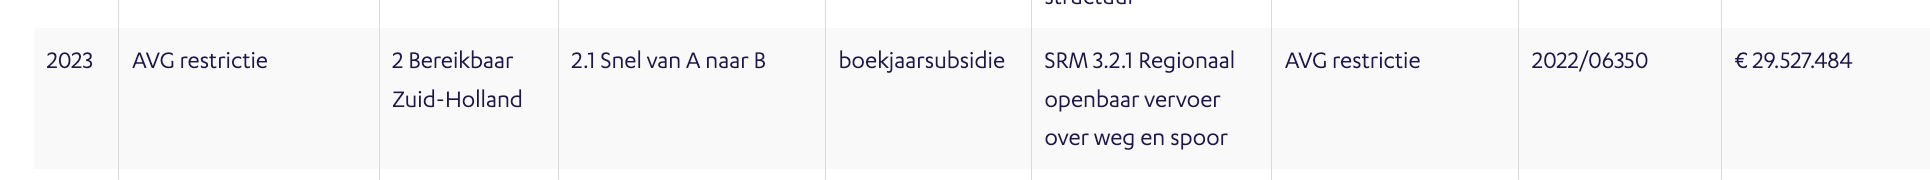